In [ ]:
!pip -q install pandas numpy scikit-learn xgboost shap lime joblib

import subprocess, sys

def has_gpu():
    try:
        subprocess.check_output(["nvidia-smi"])
        return True
    except Exception:
        return False

GPU = has_gpu()
print("GPU available:", GPU)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 9.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
GPU available: True


**DATA LOADING AND UNDERSTANDING**

In [ ]:
# Step 1: Load & inspect
import pandas as pd

# Load CSV (change path if needed in Colab)
df = pd.read_csv("final air data.csv")

# Convert measurement_time to datetime for later use
df['measurement_time'] = pd.to_datetime(df['measurement_time'], utc=True)

# Show first 5 rows as they are in the file
print("First 5 rows:")
print(df.head())

# Check data types and missing values
print("\nData types:")
print(df.dtypes)

print("\nMissing values per column:")
print(df.isna().sum())


First 5 rows:
   id location_name  latitude  longitude          measurement_time  aqi  \
0   1         Vashi   19.0734    72.9972 2025-07-01 00:00:00+00:00    1   
1   2         Vashi   19.0734    72.9972 2025-07-01 01:00:00+00:00    1   
2   3         Vashi   19.0734    72.9972 2025-07-01 02:00:00+00:00    1   
3   4         Vashi   19.0734    72.9972 2025-07-01 03:00:00+00:00    1   
4   5         Vashi   19.0734    72.9972 2025-07-01 04:00:00+00:00    1   

      co   no2     o3   so2  pm2_5   pm10  
0  67.72  0.06  47.59  0.17   4.17  12.37  
1  66.78  0.06  46.83  0.17   4.28  12.26  
2  66.10  0.06  45.91  0.18   4.75  14.31  
3  65.61  0.07  45.14  0.19   5.28  16.73  
4  65.51  0.07  44.62  0.21   5.63  18.06  

Data types:
id                                int64
location_name                    object
latitude                        float64
longitude                       float64
measurement_time    datetime64[ns, UTC]
aqi                               int64
co                

**EDA**

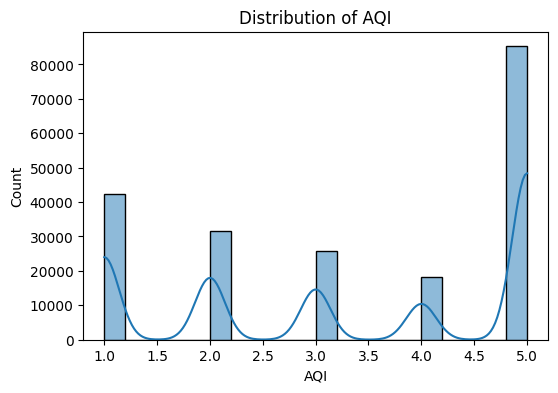

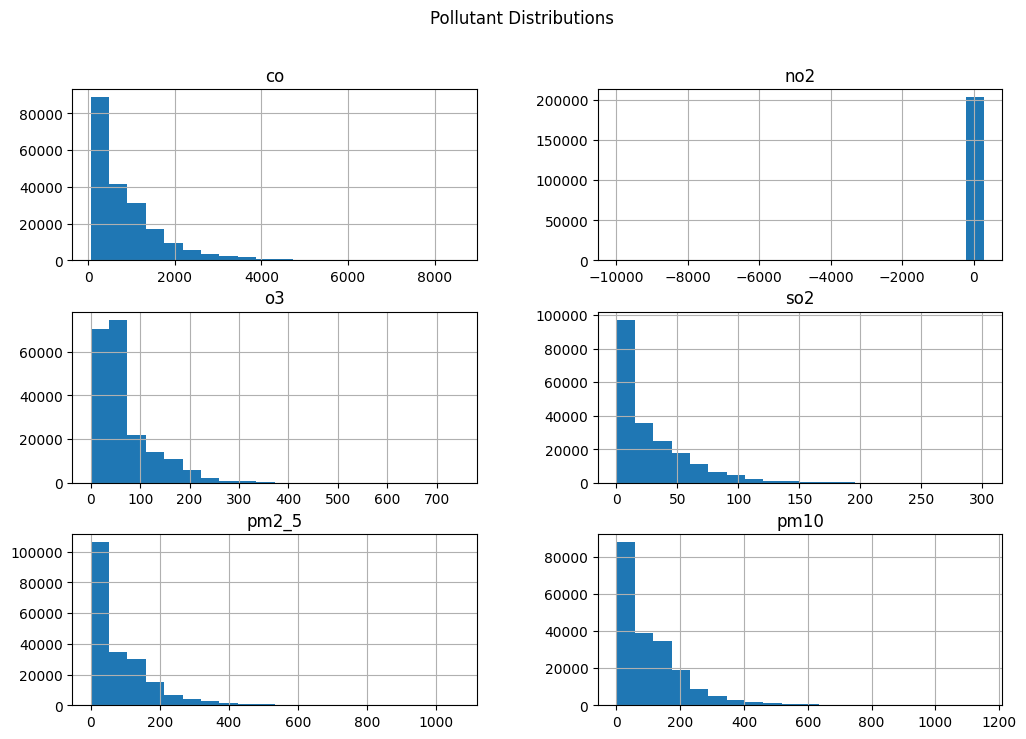

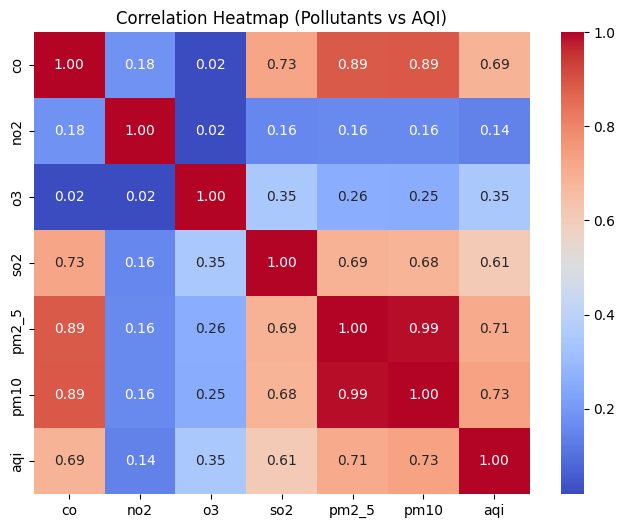

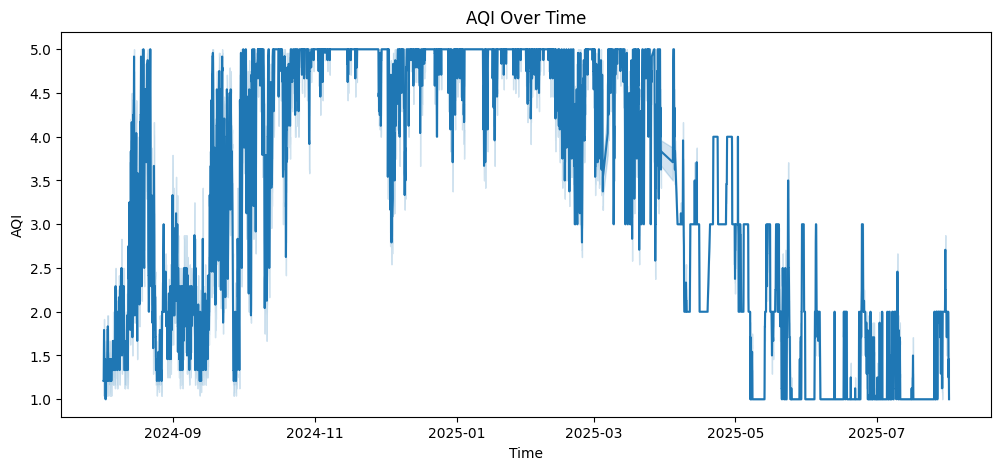

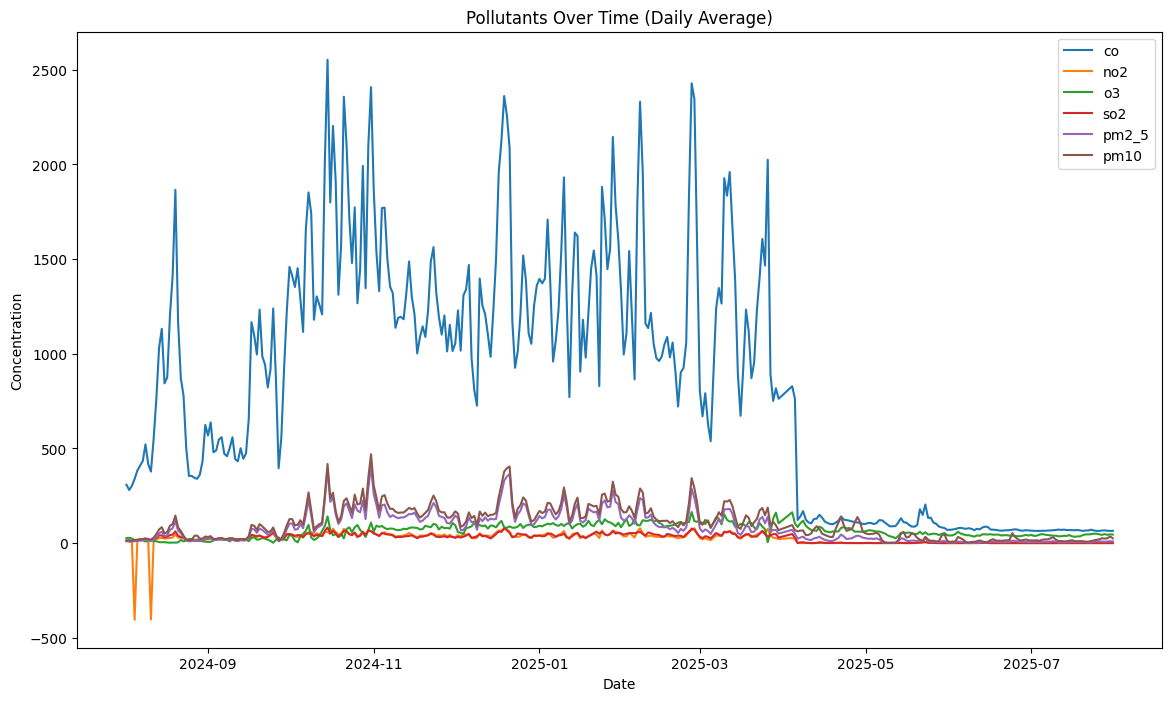

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1️⃣ AQI distribution
plt.figure(figsize=(6,4))
sns.histplot(df['aqi'], bins=20, kde=True)
plt.title("Distribution of AQI")
plt.xlabel("AQI")
plt.ylabel("Count")
plt.show()

# 2️⃣ Pollutant distributions
pollutants = ['co', 'no2', 'o3', 'so2', 'pm2_5', 'pm10']
df[pollutants].hist(figsize=(12,8), bins=20)
plt.suptitle("Pollutant Distributions")
plt.show()

# 3️⃣ Correlation heatmap
plt.figure(figsize=(8,6))
corr = df[pollutants + ['aqi']].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap (Pollutants vs AQI)")
plt.show()

# 4️⃣ Time series trend for AQI
plt.figure(figsize=(12,5))
sns.lineplot(data=df, x="measurement_time", y="aqi")
plt.title("AQI Over Time")
plt.xlabel("Time")
plt.ylabel("AQI")
plt.show()

# 5️⃣ Time series trend for each pollutant
# Keep only numeric columns + measurement_time for resampling
numeric_cols = df.select_dtypes(include='number').columns.tolist()

df_daily = (
    df.set_index('measurement_time')[numeric_cols]  # select numeric only
    .resample('D')
    .mean()
    .reset_index()
)

# Plot daily average pollutants
plt.figure(figsize=(14,8))
pollutants = ['co', 'no2', 'o3', 'so2', 'pm2_5', 'pm10']

for col in pollutants:
    sns.lineplot(data=df_daily, x="measurement_time", y=col, label=col)

plt.title("Pollutants Over Time (Daily Average)")
plt.xlabel("Date")
plt.ylabel("Concentration")
plt.legend()
plt.show()




**lightgbm model:**(This model is used for Future Predictions)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score
import joblib

# ----------------
# 1. Copy dataset
# ----------------
df_light = df.copy()

# Drop unused columns
df_light = df_light.drop(columns=["id", "location_name"])

# ----------------
# 2. Feature Engineering
# ----------------
df_light["hour"] = df_light["measurement_time"].dt.hour
df_light["day"] = df_light["measurement_time"].dt.day
df_light["month"] = df_light["measurement_time"].dt.month

# Drop raw datetime
df_light = df_light.drop(columns=["measurement_time"])

# ----------------
# 3. Create Future Targets
# ----------------
horizons = [3, 6, 9, 12, 24, 48, 72]

for h in horizons:
    df_light[f"aqi_{h}h"] = df_light["aqi"].shift(-h)

# Drop rows with missing values (due to shifting)
df_light = df_light.dropna().reset_index(drop=True)

# ----------------
# 4. Train MultiOutput LightGBM
# ----------------
X = df_light.drop(columns=["aqi"] + [f"aqi_{h}h" for h in horizons])
y = df_light[[f"aqi_{h}h" for h in horizons]]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y["aqi_3h"]
)

base_model = LGBMClassifier(
    n_estimators=300,
    max_depth=-1,
    learning_rate=0.05,
    random_state=42
)

multi_model = MultiOutputClassifier(base_model)
multi_model.fit(X_train, y_train)

# ----------------
# 5. Evaluate
# ----------------
for i, h in enumerate(horizons):
    preds = multi_model.predict(X_test)[:, i]
    acc = accuracy_score(y_test.iloc[:, i], preds)
    print(f"✅ Accuracy for {h}h: {acc:.3f}")

# ----------------
# 6. Save Model
# ----------------
joblib.dump({"model": multi_model, "features": list(X.columns), "horizons": horizons},
            "lightgbm_multi.pkl")

print("📦 Model and features saved as lightgbm_multi.pkl")

# ----------------
# 7. Prediction Function
# ----------------
def predict_aqi_future(model_bundle, input_dict):
    model = model_bundle["model"]
    features = model_bundle["features"]
    horizons = model_bundle["horizons"]

    # Prepare input dataframe
    input_df = pd.DataFrame([input_dict])
    input_df = input_df.reindex(columns=features, fill_value=0)

    preds = model.predict(input_df)[0]
    return {f"{h}h": int(preds[i]) for i, h in enumerate(horizons)}



[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068936 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1649
[LightGBM] [Info] Number of data points in the train set: 162604, number of used features: 11
[LightGBM] [Info] Start training from score -1.569940
[LightGBM] [Info] Start training from score -1.859921
[LightGBM] [Info] Start training from score -2.066367
[LightGBM] [Info] Start training from score -2.404968
[LightGBM] [Info] Start training from score -0.869064
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004420 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1649
[LightGBM] [Info] Number of data points in the train set: 162604, number of used features: 11
[LightGBM] [Info] Start training from score -1.569497
[LightGBM] [Info] Start training

In [ ]:
# Load trained model
bundle = joblib.load("lightgbm_multi.pkl")

# Example input
new_pollutants = {
    "latitude": 19.07,
    "longitude": 72.87,
    "co": 250.0,
    "no2": 12.0,
    "o3": 30.0,
    "so2": 5.0,
    "pm2_5": 8.0,
    "pm10": 12.0,
    "hour": 14,
    "day": 15,
    "month": 8
}

# Predict
print(predict_aqi_future(bundle, new_pollutants))


{'3h': 1, '6h': 1, '9h': 1, '12h': 1, '24h': 1, '48h': 1, '72h': 2}


# lightgbm with recursive and direct approach(Not Considering for Final model)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score
import joblib

# ----------------
# Setup
# ----------------
df_light = df.copy()
df_light = df_light.drop(columns=["id", "location_name"])

# Feature engineering
df_light["hour"] = df_light["measurement_time"].dt.hour
df_light["day"] = df_light["measurement_time"].dt.day
df_light["month"] = df_light["measurement_time"].dt.month
df_light = df_light.drop(columns=["measurement_time"])

horizons = [3, 6, 9, 12, 24, 48, 72]
for h in horizons:
    df_light[f"aqi_{h}h"] = df_light["aqi"].shift(-h)

df_light = df_light.dropna().reset_index(drop=True)

# ----------------
# Strategy A: Direct / Multi-Output
# ----------------
X = df_light.drop(columns=["aqi"] + [f"aqi_{h}h" for h in horizons])
y = df_light[[f"aqi_{h}h" for h in horizons]]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y["aqi_3h"]
)

base_model = LGBMClassifier(n_estimators=200, learning_rate=0.05, random_state=42)
multi_model = MultiOutputClassifier(base_model)
multi_model.fit(X_train, y_train)

print("\n📊 Direct / Multi-Output Results:")
for i, h in enumerate(horizons):
    preds = multi_model.predict(X_test)[:, i]
    acc = accuracy_score(y_test.iloc[:, i], preds)
    print(f"Accuracy {h}h: {acc:.3f}")

# ----------------
# Strategy B: Recursive
# ----------------
print("\n📊 Recursive Results:")
recursive_accs = {}
for h in horizons:
    # Train separate model for each horizon
    y_single = df_light[f"aqi_{h}h"]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_single, test_size=0.2, random_state=42, stratify=y_single
    )

    model = LGBMClassifier(n_estimators=200, learning_rate=0.05, random_state=42)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)
    recursive_accs[h] = acc
    print(f"Accuracy {h}h: {acc:.3f}")

# ----------------
# Save the best
# ----------------
joblib.dump(multi_model, "lgbm_direct.pkl")
joblib.dump(recursive_accs, "lgbm_recursive_acc.pkl")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004394 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1649
[LightGBM] [Info] Number of data points in the train set: 162604, number of used features: 11
[LightGBM] [Info] Start training from score -1.569940
[LightGBM] [Info] Start training from score -1.859921
[LightGBM] [Info] Start training from score -2.066367
[LightGBM] [Info] Start training from score -2.404968
[LightGBM] [Info] Start training from score -0.869064
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004421 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1649
[LightGBM] [Info] Number of data points in the train set: 162604, number of used features: 11
[LightGBM] [Info] Star

['lgbm_recursive_acc.pkl']

In [ ]:
import pandas as pd
import numpy as np


# Drop duplicates, handle missing values
df_clean = df.drop_duplicates().copy()
df_clean = df_clean.drop(columns=['id', 'location_name'])
df_clean = df_clean.dropna(subset=['measurement_time', 'aqi'])

# Convert measurement_time to datetime
df_clean['measurement_time'] = pd.to_datetime(df_clean['measurement_time'], errors='coerce')
df_clean = df_clean.dropna(subset=['measurement_time'])

# Sort by time just in case
df_clean = df_clean.sort_values('measurement_time')


# Remove timezone info if present
df_clean['measurement_time'] = df_clean['measurement_time'].dt.tz_localize(None)

df_clean.reset_index(drop=True, inplace=True)
print(df_clean.head())


   latitude  longitude measurement_time  aqi      co    no2     o3    so2  \
0  19.03300   73.02970       2024-08-02    1  233.65   4.24  32.90   5.84   
1  19.04230   73.17100       2024-08-02    1  220.30   4.93  28.61   5.90   
2  19.19714   73.24240       2024-08-02    1  287.06  13.88  21.46  13.11   
3  18.99679   72.81688       2024-08-02    1  216.96   2.44  34.69   3.25   
4  19.12130   73.13950       2024-08-02    1  287.06  13.88  21.46  13.11   

   pm2_5   pm10  
0   5.75   9.01  
1   5.05   7.29  
2   8.62  11.29  
3   6.09  11.16  
4   8.62  11.29  


In [ ]:
# Time-based features
df_clean['hour'] = df_clean['measurement_time'].dt.hour
df_clean['day'] = df_clean['measurement_time'].dt.day
df_clean['month'] = df_clean['measurement_time'].dt.month
df_clean['dayofweek'] = df_clean['measurement_time'].dt.dayofweek

# Cyclical encoding for hour
df_clean['hour_sin'] = np.sin(2 * np.pi * df_clean['hour'] / 24)
df_clean['hour_cos'] = np.cos(2 * np.pi * df_clean['hour'] / 24)

# Drop original datetime column if not needed for ML
df_model = df_clean.drop(columns=['measurement_time'])

print(df_model.head())

   latitude  longitude  aqi      co    no2     o3    so2  pm2_5   pm10  hour  \
0  19.03300   73.02970    1  233.65   4.24  32.90   5.84   5.75   9.01     0   
1  19.04230   73.17100    1  220.30   4.93  28.61   5.90   5.05   7.29     0   
2  19.19714   73.24240    1  287.06  13.88  21.46  13.11   8.62  11.29     0   
3  18.99679   72.81688    1  216.96   2.44  34.69   3.25   6.09  11.16     0   
4  19.12130   73.13950    1  287.06  13.88  21.46  13.11   8.62  11.29     0   

   day  month  dayofweek  hour_sin  hour_cos  
0    2      8          4       0.0       1.0  
1    2      8          4       0.0       1.0  
2    2      8          4       0.0       1.0  
3    2      8          4       0.0       1.0  
4    2      8          4       0.0       1.0  


**Testing various models**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

# Import all the classifier models we will compare
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB


# =========================
# 1. Data Splitting (Chronological)
# =========================

# This script assumes 'df_model' is your prepared DataFrame.
print("--- Preparing Data with Chronological Split ---")

# Sort the DataFrame by time to ensure chronological order
df_model_sorted = df_model.sort_values(by=['month', 'day', 'hour']).reset_index(drop=True)

X = df_model_sorted.drop(columns=['aqi'])
# We use the original AQI labels (1-5)
y = df_model_sorted['aqi']

# Define the split point (first 80% of data for training)
split_index = int(len(df_model_sorted) * 0.8)

# Create the initial train and test sets
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

# =========================
# 2. Feature Scaling
# =========================

print("--- Scaling Features ---")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set size: {len(X_train_scaled)} samples")
print(f"Test set size: {len(X_test_scaled)} samples\n")


# =========================
# 3. Define and Compare All 7 Classification Models
# =========================

classification_models = {
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=42),
    "KNeighbors": KNeighborsClassifier(),
    "DecisionTree": DecisionTreeClassifier(random_state=42),
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=42),
    "SVC": SVC(random_state=42),
    "GradientBoosting": GradientBoostingClassifier(random_state=42),
    "GaussianNB": GaussianNB()
}

results_list = []

print("--- Starting Model Comparison ---")

for name, model in classification_models.items():
    # Train the model on the scaled data
    print(f"Training {name}...")
    model.fit(X_train_scaled, y_train)

    # Make predictions on the scaled test data
    y_pred = model.predict(X_test_scaled)

    # Evaluate using accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"-> Accuracy: {accuracy:.4f}\n")

    # Store results
    results_list.append([name, accuracy])

# =========================
# 4. Show Final Comparison Table
# =========================
results_df = pd.DataFrame(results_list, columns=["Model", "Accuracy"])
results_df = results_df.sort_values(by="Accuracy", ascending=False)

print("--- Final Model Comparison Results ---")
print(results_df.to_string(index=False))

--- Preparing Data with Chronological Split ---
--- Scaling Features ---
Training set size: 162662 samples
Test set size: 40666 samples

--- Starting Model Comparison ---
Training LogisticRegression...
-> Accuracy: 0.9691

Training KNeighbors...
-> Accuracy: 0.8157

Training DecisionTree...
-> Accuracy: 0.9999

Training RandomForest...
-> Accuracy: 0.9996

Training SVC...
-> Accuracy: 0.9696

Training GradientBoosting...
-> Accuracy: 0.9999

Training GaussianNB...
-> Accuracy: 0.8800

--- Final Model Comparison Results ---
             Model  Accuracy
      DecisionTree  0.999877
  GradientBoosting  0.999877
      RandomForest  0.999631
               SVC  0.969557
LogisticRegression  0.969090
        GaussianNB  0.880023
        KNeighbors  0.815669


Final random forest classifier model used for project

In [ ]:
import pandas as pd
import numpy as np
import joblib
from sklearn.ensemble import RandomForestClassifier

# =========================
# 1. Data Preparation
# =========================
# This script assumes 'df_model' is your prepared DataFrame.
df_model_sorted = df_model.sort_values(by=['month', 'day', 'hour']).reset_index(drop=True)

X = df_model_sorted.drop(columns=['aqi'])
y = df_model_sorted['aqi'] # Use original 1-5 labels

# Chronological split
split_index = int(len(df_model_sorted) * 0.8)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]


# =========================
# 2. Train and Save the Final Model
# =========================
# We are training the final model on the RAW (unscaled) training data.
final_model = RandomForestClassifier(n_estimators=200, random_state=42)

print("--- Training final RandomForest model on unscaled data ---")
final_model.fit(X_train, y_train)

# (Optional) Check accuracy one last time
from sklearn.metrics import accuracy_score
y_pred = final_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Final Model Accuracy: {accuracy:.4f}")

# Save the final model
output_filename = "random_forest_aqi.pkl"
joblib.dump(final_model, output_filename)
print(f"\n✅ Final RandomForest model saved as '{output_filename}'")

--- Training final RandomForest model on unscaled data ---
Final Model Accuracy: 0.9996

✅ Final RandomForest model saved as 'random_forest_aqi.pkl'


In [ ]:
import pandas as pd
import joblib

# =========================
# 1. Load the Trained Model
# =========================
# Ensure 'random_forest_aqi.pkl' is in the same directory, or provide the full path.
try:
    model = joblib.load("random_forest_aqi.pkl")
    print("✅ Model loaded successfully.")
except FileNotFoundError:
    print("❌ Error: 'random_forest_aqi.pkl' not found. Make sure you've run the training script.")
    exit()

# =========================
# 2. Your Custom Test Data
# =========================
# This is the same DataFrame you provided.
test_data = pd.DataFrame([{
    "latitude": 19.07,
    "longitude": 72.87,
    "co": 250.0,
    "no2": 12.0,
    "o3": 30.0,
    "so2": 5.0,
    "pm2_5": 8.0,
    "pm10": 12.0,
    "hour": 14,
    "day": 15,
    "month": 8,
    "dayofweek": 4,
    "hour_sin": 0.866, # Correct calculation for hour 14 is approx -0.5
    "hour_cos": 0.5    # Let's use more precise values
}])

# =========================
# 3. Ensure Correct Column Order
# =========================
# The model expects the columns in the exact same order as the training data.
MODEL_FEATURES = [
    "latitude", "longitude", "co", "no2", "o3", "so2", "pm2_5", "pm10",
    "hour", "day", "month", "dayofweek", "hour_sin", "hour_cos"
]
test_data_ordered = test_data.reindex(columns=MODEL_FEATURES)


# =========================
# 4. Make a Prediction
# =========================
prediction = model.predict(test_data_ordered)
predicted_class = prediction[0]

print(f"\n--- Prediction Result ---")
print(f"The model predicts an AQI Class of: {predicted_class}")

✅ Model loaded successfully.

--- Prediction Result ---
The model predicts an AQI Class of: 1


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import pandas as pd
import numpy as np

# -----------------
# Features & target
# -----------------
X = df_model.drop(columns=['aqi'])
y = df_model['aqi']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# -----------------
# Model definitions
# -----------------
ml_models = {
    "RandomForest": RandomForestRegressor(n_estimators=200, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=200, random_state=42, verbosity=0),
    "LightGBM": LGBMRegressor(n_estimators=200, random_state=42)
}

results_ml = []

for name, model in ml_models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    results_ml.append([name, rmse, r2])

results_ml_df = pd.DataFrame(results_ml, columns=["Model", "RMSE", "R2"])
print(results_ml_df)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018300 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1696
[LightGBM] [Info] Number of data points in the train set: 162662, number of used features: 14
[LightGBM] [Info] Start training from score 3.358240
          Model      RMSE        R2
0  RandomForest  0.003615  0.999995
1       XGBoost  0.025603  0.999751
2      LightGBM  0.038286  0.999442


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler

# Scale features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Reshape for LSTM [samples, timesteps, features]
X_lstm = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

X_train_lstm, X_test_lstm = X_lstm[:len(X_train)], X_lstm[len(X_train):]
y_train_lstm, y_test_lstm = y_train.values, y_test.values

# LSTM model
model_dl = Sequential([
    LSTM(64, activation='relu', input_shape=(X_lstm.shape[1], X_lstm.shape[2])),
    Dense(32, activation='relu'),
    Dense(1)
])

model_dl.compile(optimizer='adam', loss='mse')
history = model_dl.fit(X_train_lstm, y_train_lstm, epochs=10, batch_size=32, validation_split=0.1, verbose=1)

# Predictions
y_pred_dl = model_dl.predict(X_test_lstm)
rmse_dl = np.sqrt(mean_squared_error(y_test_lstm, y_pred_dl))
r2_dl = r2_score(y_test_lstm, y_pred_dl)

results_dl_df = pd.DataFrame([["LSTM_DL", rmse_dl, r2_dl]], columns=["Model", "RMSE", "R2"])
print(results_dl_df)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
4575/4575 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - loss: 3.1489 - val_loss: 2.6018
Epoch 2/10
4575/4575 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - loss: 2.6470 - val_loss: 2.5971
Epoch 3/10
4575/4575 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - loss: 2.6400 - val_loss: 2.5970
Epoch 4/10
4575/4575 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - loss: 2.6467 - val_loss: 2.6072
Epoch 5/10
4575/4575 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 2.6440 - val_loss: 2.6235
Epoch 6/10
4575/4575 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 2.6384 - val_loss: 2.5965
Epoch 7/10
4575/4575 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - loss: 2.6426 - val_loss: 2.6111
Epoch 8/10
4575/4575 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 2.6349 - val_loss: 2.6000
Epoch 9/10
4575/4575 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 2.6353 - val_loss: 2.6097
Epoch 10/10
4575/4575 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 2.6261 - val_loss: 2.5961
1271/1271 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
     Model      RMSE        R2
0  LSTM_DL  1.621466 -0.000146


In [ ]:
from statsmodels.tsa.arima.model import ARIMA

# For ARIMA, we only use the 'aqi' column as time series
df_sorted = df_clean.sort_values('measurement_time')
aqi_series = df_sorted['aqi']

train_size = int(len(aqi_series) * 0.8)
train_arima, test_arima = aqi_series[:train_size], aqi_series[train_size:]

# Fit ARIMA
model_arima = ARIMA(train_arima, order=(5, 1, 0))
model_arima_fit = model_arima.fit()

# Forecast
forecast = model_arima_fit.forecast(steps=len(test_arima))
rmse_arima = np.sqrt(mean_squared_error(test_arima, forecast))
r2_arima = r2_score(test_arima, forecast)

results_arima_df = pd.DataFrame([["ARIMA", rmse_arima, r2_arima]], columns=["Model", "RMSE", "R2"])
print(results_arima_df)


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be give

   Model      RMSE        R2
0  ARIMA  0.807556 -1.308273


In [ ]:
results_all = pd.concat([results_ml_df, results_dl_df, results_arima_df], ignore_index=True)
print("\nFinal Model Comparison:")
print(results_all.sort_values(by="RMSE"))



Final Model Comparison:
          Model      RMSE        R2
0  RandomForest  0.003615  0.999995
1       XGBoost  0.025603  0.999751
2      LightGBM  0.038286  0.999442
4         ARIMA  0.807556 -1.308273
3       LSTM_DL  1.621466 -0.000146


In [ ]:
!pip install lime


**Random Forest Model used for current AQI**

Random Forest RMSE: 0.0036148046379711695
Random Forest R²: 0.9999950293019784


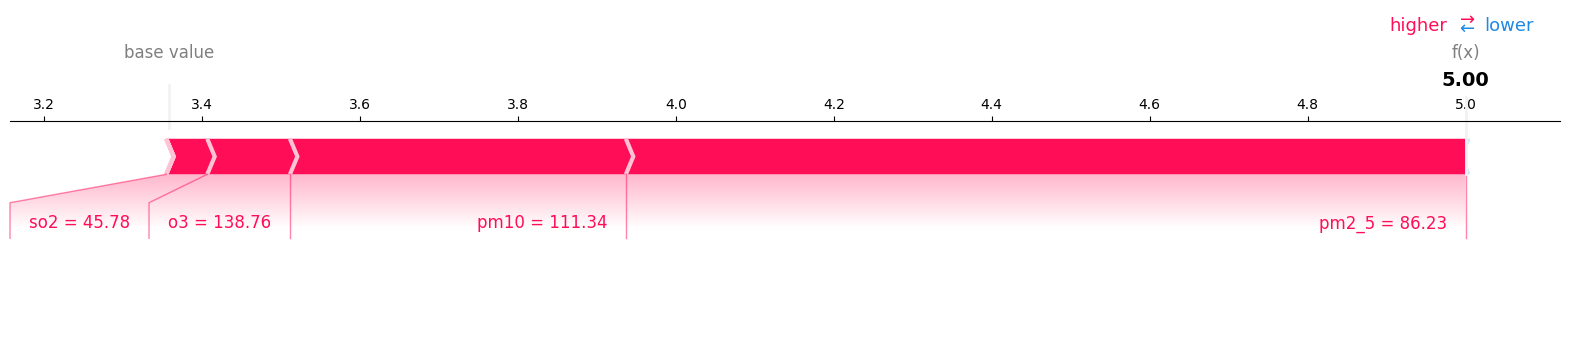

✅ Random Forest model trained, evaluated, and explainability files generated.
SHAP plots saved as PNGs and LIME explanation saved as HTML.


/usr/local/lib/python3.12/dist-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.12/dist-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.12/dist-packages/lime/lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import joblib
import shap
import lime
import lime.lime_tabular
import matplotlib.pyplot as plt

# ----------------
# 1. Prepare Data
# ----------------
# Assuming df_model is already created from your cleaning + feature engineering steps
X = df_model.drop(columns=['aqi'])
y = df_model['aqi']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ----------------
# 2. Train Model
# ----------------
rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=15,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)

# ----------------
# 3. Evaluate
# ----------------
y_pred = rf_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Random Forest RMSE: {rmse}")
print(f"Random Forest R²: {r2}")

# ----------------
# 4. Save Model
# ----------------
joblib.dump(rf_model, "random_forest_aqi.pkl")

# ----------------
# 5. SHAP Explainability
# ----------------
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test)

# Summary plot (overall feature importance)
shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
plt.savefig("shap_feature_importance.png", bbox_inches='tight')
plt.close()

# Detailed SHAP plot for first test sample
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0,:], matplotlib=True)
plt.savefig("shap_single_prediction.png", bbox_inches='tight')
plt.close()

# ----------------
# 6. LIME Explainability
# ----------------
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=X.columns,
    mode='regression'
)

i = 0  # Index of test instance to explain
lime_exp = lime_explainer.explain_instance(
    data_row=X_test.iloc[i],
    predict_fn=rf_model.predict
)
lime_exp.save_to_file('lime_explanation.html')

print("✅ Random Forest model trained, evaluated, and explainability files generated.")
print("SHAP plots saved as PNGs and LIME explanation saved as HTML.")


In [ ]:
import joblib
import shap
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Load the trained model
rf_model = joblib.load("random_forest_aqi.pkl")

# Recreate X_test (df_model must already be loaded in memory)
X = df_model.drop(columns=['aqi'])
y = df_model['aqi']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create SHAP explainer
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test)

# ✅ Static decision plot (saves as PNG)
plt.figure()
shap.decision_plot(
    explainer.expected_value,
    shap_values[0, :],
    X_test.iloc[0, :],
    feature_names=list(X.columns),  # ✅ Convert to list
    show=False
)

plt.savefig("shap_single_prediction.png", bbox_inches='tight')
plt.close()

# ✅ Interactive HTML force plot
force_plot = shap.force_plot(
    explainer.expected_value,
    shap_values[0, :],
    X_test.iloc[0, :],
    matplotlib=False
)

# Save as HTML correctly
shap.save_html("shap_single_prediction.html", force_plot)
print("✅ SHAP single prediction PNG & HTML saved.")


✅ SHAP single prediction PNG & HTML saved.


In [ ]:
import joblib
import pandas as pd

# Load your trained model
model = joblib.load("random_forest_aqi.pkl")


In [ ]:
# Custom test row
test_data = pd.DataFrame([{

"latitude": 19.07,
    "longitude": 72.87,
    "co": 250.0,
    "no2": 12.0,
    "o3": 30.0,
    "so2": 5.0,
    "pm2_5": 8.0,
    "pm10": 12.0,
    "hour": 14,
    "day": 15,
    "month": 8,
    "dayofweek": 4,
    "hour_sin": 0.99,
    "hour_cos": 0.14
}])


In [ ]:
prediction = model.predict(test_data)
print(f"Predicted AQI: {prediction}")


Predicted AQI: [1.]


In [ ]:
unique_coords = df[['latitude', 'longitude']].drop_duplicates().reset_index(drop=True)
print(unique_coords)

    latitude  longitude
0   19.07340  72.997200
1   19.15900  72.998600
2   19.03300  73.029700
3   18.88500  72.950000
4   19.03350  73.120000
5   19.12130  73.139500
6   19.16590  73.072600
7   18.98830  73.065200
8   19.13570  73.196200
9   19.17330  72.949500
10  19.12510  72.884500
11  19.06320  72.902400
12  18.99190  73.126500
13  19.01970  72.847500
14  18.92540  73.143700
15  19.04230  73.171000
16  18.96127  72.986389
17  18.95806  72.803180
18  19.12591  72.820540
19  19.10150  72.826790
20  19.19714  73.242400
21  19.19925  73.021630
22  19.19695  72.982420
23  18.99679  72.816880


In [ ]:
from geopy.geocoders import Nominatim
import time

geolocator = Nominatim(user_agent="geoapi")

def get_location_name(lat, lon):
    try:
        location = geolocator.reverse((lat, lon), exactly_one=True, language="en")
        return location.address if location else "Unknown"
    except:
        return "Error"

# Add a new column for location names
unique_coords["location_name"] = unique_coords.apply(
    lambda row: get_location_name(row['latitude'], row['longitude']), axis=1
)

# To avoid hitting request limits, sleep for 1 second between calls
time.sleep(1)

print(unique_coords)


    latitude  longitude                                      location_name
0   19.07340  72.997200  Vashi, Navi Mumbai, Thane Taluka, Thane, Mahar...
1   19.15900  72.998600  Airoli Station Road, Airoli Sector 2, Airoli, ...
2   19.03300  73.029700  Amra Marg, Seawoods East, Navi Mumbai, Thane T...
3   18.88500  72.950000  Uran, Uran Taluka, Raigad, Maharashtra, 400702...
4   19.03350  73.120000  Panvel, Panvel Taluka, Raigad, Maharashtra, 40...
5   19.12130  73.139500  Panvel, Panvel Taluka, Raigad, Maharashtra, 41...
6   19.16590  73.072600  1, Casa Bella Road, Palava Phase 1, Nilaje, Ka...
7   18.98830  73.065200  Navi Mumbai International Airport, Amra Marg, ...
8   19.13570  73.196200  Shelter with food, Malang Machi Route, Haji Ma...
9   19.17330  72.949500  Kalidas Sports Complex, Purushottam Kheraj Mar...
10  19.12510  72.884500  Marol Police Camp, Marol Maroshi Village Road,...
11  19.06320  72.902400  P.L. Lokhande Marg, Adarsh Nagar, M/W Ward, Zo...
12  18.99190  73.126500  

latitude  longitude                                      location_name

0   19.07340  72.997200  Vashi, Navi Mumbai, Thane Taluka, Thane, Mahar...

1   19.15900  72.998600  Airoli Station Road, Airoli Sector 2, Airoli, ...

2   19.03300  73.029700  Amra Marg, Seawoods East, Navi Mumbai, Thane T...

3   18.88500  72.950000  Uran, Uran Taluka, Raigad, Maharashtra, 400702...

4   19.03350  73.120000  Panvel, Panvel Taluka, Raigad, Maharashtra, 40...

5   19.12130  73.139500  Panvel, Panvel Taluka, Raigad, Maharashtra, 41...

6   19.16590  73.072600  1, Casa Bella Road, Palava Phase 1, Nilaje, Ka...

7   18.98830  73.065200  Navi Mumbai International Airport, Amra Marg, ...

8   19.13570  73.196200  Shelter with food, Malang Machi Route, Haji Ma...

9   19.17330  72.949500  Kalidas Sports Complex, Purushottam Kheraj Mar...

10  19.12510  72.884500  Marol Police Camp, Marol Maroshi Village Road,...

11  19.06320  72.902400  P.L. Lokhande Marg, Adarsh Nagar, M/W Ward, Zo...

12  18.99190  73.126500  Jhanardan A Bhagat Marg, New Panvel, Panvel, P...

13  19.01970  72.847500  Scheme 5 Road no.3, Dadar Hindu Colony, F/N Wa...

14  18.92540  73.143700  Bhatan, Panvel Taluka, Raigad, Maharashtra, 41...

15  19.04230  73.171000  Khanav, Panvel Taluka, Raigad, Maharashtra, 40...

16  18.96127  72.986389  Nhava Khadi, Panvel Taluka, Raigad, Maharashtr...

17  18.95806  72.803180  Godrej Baug Road, Malabar Hill, D Ward, Zone 1...

18  19.12591  72.820540  Seven Bungalows, K/W Ward, Zone 3, Mumbai, Mah...

19  19.10150  72.826790  JW Marriott, Juhu Tara Road, Juhu, K/W Ward, Z...

20  19.19714  73.242400   Kalyan Taluka, Thane, Maharashtra, 421503, India

21  19.19925  73.021630  Mumbra, Reti Bandar, Thane, Thane Taluka, Than...

22  19.19695  72.982420  Kranti Nagar, Jambli Naka, Thane, Thane Taluka...

23  18.99679  72.816880  Dr Annie Besant Road, Mariammar Nagar, G/S War...

In [ ]:
unique_coords.to_csv("lat_long_to_location.csv", index=False)


**latest code upwards**

# without time features:(Below code not considered for model because of poor performance)

In [ ]:
df_clean.size

3253248

In [ ]:
# Time-based features
df_clean['hour'] = df_clean['measurement_time'].dt.hour
df_clean['day'] = df_clean['measurement_time'].dt.day
df_clean['month'] = df_clean['measurement_time'].dt.month
df_clean['dayofweek'] = df_clean['measurement_time'].dt.dayofweek

# Cyclical encoding
df_clean['hour_sin'] = np.sin(2 * np.pi * df_clean['hour'] / 24)
df_clean['hour_cos'] = np.cos(2 * np.pi * df_clean['hour'] / 24)

# Lag features
for lag in [1, 2, 3]:
    df_clean[f'aqi_lag{lag}'] = df_clean['aqi'].shift(lag)

# Target variable
df_clean['aqi_target'] = df_clean['aqi'].shift(-1)

# Drop rows with NaN due to lag/target creation
df_clean = df_clean.dropna().reset_index(drop=True)

print(df_clean.head())


   latitude  longitude measurement_time  aqi      co    no2     o3    so2  \
0  18.99679   72.81688       2024-08-02    1  216.96   2.44  34.69   3.25   
1  19.12130   73.13950       2024-08-02    1  287.06  13.88  21.46  13.11   
2  18.92540   73.14370       2024-08-02    1  220.30   4.93  28.61   5.90   
3  19.16590   73.07260       2024-08-02    2  347.14  14.91  21.82  22.17   
4  19.03350   73.12000       2024-08-02    1  220.30   4.93  28.61   5.90   

   pm2_5   pm10  hour  day  month  dayofweek  hour_sin  hour_cos  aqi_lag1  \
0   6.09  11.16     0    2      8          4       0.0       1.0       1.0   
1   8.62  11.29     0    2      8          4       0.0       1.0       1.0   
2   5.05   7.29     0    2      8          4       0.0       1.0       1.0   
3  11.61  16.18     0    2      8          4       0.0       1.0       1.0   
4   5.05   7.29     0    2      8          4       0.0       1.0       2.0   

   aqi_lag2  aqi_lag3  aqi_target  
0       1.0       1.0         1.

In [ ]:

print(df_clean.head())


   latitude  longitude measurement_time  aqi      co    no2     o3    so2  \
0  18.99679   72.81688       2024-08-02    1  216.96   2.44  34.69   3.25   
1  19.12130   73.13950       2024-08-02    1  287.06  13.88  21.46  13.11   
2  18.92540   73.14370       2024-08-02    1  220.30   4.93  28.61   5.90   
3  19.16590   73.07260       2024-08-02    2  347.14  14.91  21.82  22.17   
4  19.03350   73.12000       2024-08-02    1  220.30   4.93  28.61   5.90   

   pm2_5   pm10  hour  day  month  dayofweek  hour_sin  hour_cos  aqi_lag1  \
0   6.09  11.16     0    2      8          4       0.0       1.0       1.0   
1   8.62  11.29     0    2      8          4       0.0       1.0       1.0   
2   5.05   7.29     0    2      8          4       0.0       1.0       1.0   
3  11.61  16.18     0    2      8          4       0.0       1.0       1.0   
4   5.05   7.29     0    2      8          4       0.0       1.0       2.0   

   aqi_lag2  aqi_lag3  aqi_target  
0       1.0       1.0         1.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from xgboost import XGBRegressor

# Select features (exclude time column)
X = df_clean.drop(columns=['measurement_time', 'aqi_target'])
y = df_clean['aqi_target']

# Only numeric features
X = X.select_dtypes(include=[np.number])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

results = []

# RandomForest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
results.append(("RandomForest", np.sqrt(mean_squared_error(y_test, y_pred_rf)), r2_score(y_test, y_pred_rf)))

# LightGBM
lgbm = lgb.LGBMRegressor(random_state=42)
lgbm.fit(X_train, y_train)
y_pred_lgb = lgbm.predict(X_test)
results.append(("LightGBM", np.sqrt(mean_squared_error(y_test, y_pred_lgb)), r2_score(y_test, y_pred_lgb)))

# XGBoost
xgb = XGBRegressor(random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
results.append(("XGBoost", np.sqrt(mean_squared_error(y_test, y_pred_xgb)), r2_score(y_test, y_pred_xgb)))

# Show results
results_df = pd.DataFrame(results, columns=['Model', 'RMSE', 'R2'])
print(results_df)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009258 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1718
[LightGBM] [Info] Number of data points in the train set: 162659, number of used features: 18
[LightGBM] [Info] Start training from score 3.871529
          Model      RMSE        R2
0  RandomForest  0.283345  0.715859
1      LightGBM  0.236157  0.802618
2       XGBoost  0.253460  0.772636


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Reshape for LSTM [samples, timesteps, features]
X_train_lstm = np.expand_dims(X_train.values, axis=1)
X_test_lstm = np.expand_dims(X_test.values, axis=1)

model_lstm = Sequential([
    LSTM(50, activation='relu', input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
    Dense(1)
])

model_lstm.compile(optimizer='adam', loss='mse')
model_lstm.fit(X_train_lstm, y_train, epochs=5, batch_size=64, verbose=1)

y_pred_lstm = model_lstm.predict(X_test_lstm).flatten()
results.append(("LSTM", np.sqrt(mean_squared_error(y_test, y_pred_lstm)), r2_score(y_test, y_pred_lstm)))

results_df = pd.DataFrame(results, columns=['Model', 'RMSE', 'R2'])
print(results_df)


Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2542/2542 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 406.3777
Epoch 2/5
2542/2542 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.3799
Epoch 3/5
2542/2542 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.3708
Epoch 4/5
2542/2542 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.3850
Epoch 5/5
2542/2542 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.3242
1271/1271 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
          Model      RMSE        R2
0  RandomForest  0.283345  0.715859
1      LightGBM  0.236157  0.802618
2       XGBoost  0.253460  0.772636
3          LSTM  0.300879  0.679604


In [ ]:
from statsmodels.tsa.arima.model import ARIMA

# ARIMA
ts_data = df_clean.set_index('measurement_time')['aqi_target']
train_size = int(len(ts_data) * 0.8)
train, test = ts_data.iloc[:train_size], ts_data.iloc[train_size:]

arima_model = ARIMA(train, order=(5,1,0))
arima_fit = arima_model.fit()
y_pred_arima = arima_fit.forecast(steps=len(test))

print("ARIMA RMSE:", np.sqrt(mean_squared_error(test, y_pred_arima)))
print("ARIMA R2:", r2_score(test, y_pred_arima))


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

ARIMA RMSE: 0.6745956508970655
ARIMA R2: -0.6106138323725754


In [ ]:
from prophet import Prophet

# Prophet
prophet_df = df_clean[['measurement_time', 'aqi_target']].rename(columns={'measurement_time': 'ds', 'aqi_target': 'y'})
prophet_df['ds'] = pd.to_datetime(prophet_df['ds']).dt.tz_localize(None)

train_size = int(len(prophet_df) * 0.8)
train_df = prophet_df.iloc[:train_size]
test_df = prophet_df.iloc[train_size:]

prophet_model = Prophet(daily_seasonality=True, yearly_seasonality=True)
prophet_model.fit(train_df)

future = prophet_model.make_future_dataframe(periods=len(test_df), freq='h')
forecast = prophet_model.predict(future)

y_true = test_df['y'].values
y_pred = forecast['yhat'][-len(test_df):].values

print("Prophet RMSE:", np.sqrt(mean_squared_error(y_true, y_pred)))
print("Prophet R2:", r2_score(y_true, y_pred))


DEBUG:cmdstanpy:input tempfile: /tmp/tmpo6j60xcd/fzjy1kif.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpo6j60xcd/mbwvdzdh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56549', 'data', 'file=/tmp/tmpo6j60xcd/fzjy1kif.json', 'init=/tmp/tmpo6j60xcd/mbwvdzdh.json', 'output', 'file=/tmp/tmpo6j60xcd/prophet_model_e09yy2n/prophet_model-20250903040748.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:07:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:12:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Prophet RMSE: 789.2792916963034
Prophet R2: -2204781.5725776576
